In [1]:
import sys
sys.path.insert(0, '../tracing_analysis')
import navis
import pymaid
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import importlib
import pandas as pd
import pickle
from scipy import stats as stats
import h5py
import analysis_dataframes as myDF
import ppc_analysis_functions.catmaid_API as cAPI
import ppc_analysis_functions.figure_plotting as figs
importlib.reload(figs)

cwd = os.getcwd()
figsDir = os.sep.join([cwd,'fig_panels/'])
workingDir = os.sep.join([os.path.dirname(cwd), 'analysis_dataframes/'])
# Define LR colormap and make colorbar
pal = {'anti':'#ba48cf', 'co':'#2CB899'} # darker
order = ['anti','co']

def avg_lr(row):
    try:
        return (row['Ca_trial_mean_bR']+row['Ca_trial_mean_wL'])/2
    except:
        return np.nan

def find_max_idx(Ca):
    if np.isnan(Ca).any():
        return np.nan
    else:
        return np.nanargmax(Ca)

def color_epochs(ax3):
    ylim = ax3.get_ylim()
    ax3.fill_between(t_cueEarly,0,ylim[1], facecolor=colors['cueEarly'], alpha=0.2)
    ax3.fill_between(t_cueLate,0,ylim[1], facecolor=colors['cueLate'], alpha=0.2)
    ax3.fill_between(t_delay,0,ylim[1], facecolor=colors['delay'], alpha=0.2)
    ax3.fill_between(t_turn,0,ylim[1], facecolor=colors['turn'], alpha=0.2)
    ax3.fill_between(t_ITI,0,ylim[1], facecolor=colors['ITI'], alpha=0.2)

<Figure size 640x480 with 0 Axes>

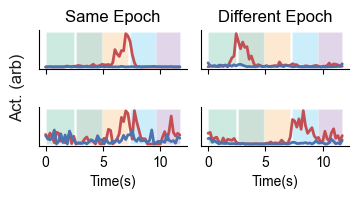

In [3]:
# ED Fig. 7a: Plot example neuron activity and MI
with open(workingDir+'MN_DF_1sess_PPC.pkl' , 'rb') as f:  
    my_DF = pickle.load(f)

# asynchronous:
a1 = my_DF[my_DF.skeleton_id == 22901]
a2 = my_DF[my_DF.skeleton_id == 140120]

# synchronous
s1 = my_DF[my_DF.skeleton_id == 143896 ]
s2 = my_DF[my_DF.skeleton_id == 141681]

plt.style.use('default')
plt.rcParams['font.size'] = '10'
fig=plt.figure()


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(4, 1.5),ncols=2, nrows=2, sharey=False, sharex=True)
sns.set(rc={'figure.figsize':(4,1.5)}, font_scale=1, style='ticks')
plt.subplots_adjust(wspace=0.1, hspace = 1)

t = np.linspace(0,62,num=63)/5.3
t_cueEarly = t[0:13+1]
t_cueLate = t[14:26+1]
t_delay = t[26:38+1]
t_turn = t[39:51+1]
t_ITI = t[51:62+1]
colors = {'cueEarly':'#019966', 'cueLate':'#006838', 'delay':'#f7941d',
    'turn':'#00aeef','ITI':'#662d91'}


ax1.plot(t,s1['Ca_trial_mean_bR'].values[0],'r-', linewidth=2, alpha=1)
ax1.plot(t,s1['Ca_trial_mean_wL'].values[0],'b-',linewidth=2, alpha=1)
#ax.set_ylabel('Act. (arb)', color='k')
ax1.get_yaxis().set_visible(False)
ax1.set_title('Same Epoch')
color_epochs(ax1)

ax3.plot(t,s2['Ca_trial_mean_bR'].values[0],'r-', linewidth=2, alpha=1)
ax3.plot(t,s2['Ca_trial_mean_wL'].values[0],'b-',linewidth=2, alpha=1)
ax3.get_yaxis().set_visible(False)
#ax3.set_yticks([])
#ax2.legend(['Right', 'Left'], prop={"size":7})
ax3.set_xlabel('Time(s)')
color_epochs(ax3)

ax2.plot(t,a1['Ca_trial_mean_bR'].values[0],'r-', linewidth=2, alpha=1)
ax2.plot(t,a1['Ca_trial_mean_wL'].values[0],'b-',linewidth=2, alpha=1)
ax2.get_yaxis().set_visible(False)
ax2.set_title('Different Epoch')
#ax2.set_ylabel('Act. (arb)', color='k')
color_epochs(ax2)
ax4.plot(t,a2['Ca_trial_mean_bR'].values[0],'r-', linewidth=2, alpha=1)
ax4.plot(t,a2['Ca_trial_mean_wL'].values[0],'b-',linewidth=2, alpha=1)
ax4.get_yaxis().set_visible(False)
ax4.set_xlabel('Time(s)')
color_epochs(ax4)
#ax4.set_yticks([])

ax = fig.add_subplot(121, frameon=False)
#ax.get_yaxis().set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel('Act. (arb)', color='k')

ax = fig.add_subplot(122, frameon=False)
#ax.get_yaxis().set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel(None)
sns.despine()

plt.savefig(figsDir+'ex_synch_asynch.pdf',bbox_inches='tight')

E-to-I connected 24/113 same, 21.2 percent
E-to-I non-connected 122/469 same, 26.0 percent


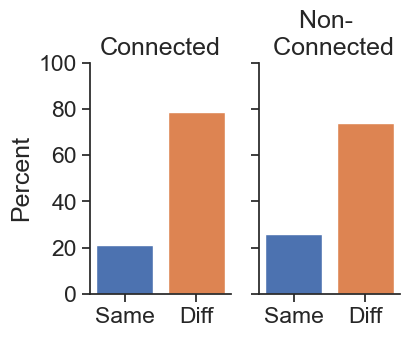

In [5]:
# ED 7c/d: E-to-I with same/different epochs
# Number of same / diff connections

#cn_type = 'E-to-I'
cn_type = 'I-to-E'

sns.set(rc={'figure.figsize':(4,3)}, font_scale=1.5, style='ticks')
fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]},sharey=True)

with open(workingDir + 'pot_dir_cn_DF_PPC.pkl' , 'rb') as f:  
    pot_cns = pickle.load(f)
pot_cns['pair_epoch'] = pd.Categorical(pot_cns['pair_epoch'], ['Same','Diff'])

if cn_type == 'E-to-I':
    pot_cns = pot_cns[pot_cns.cn_type == 'E-I']
elif cn_type == 'I-to-E':
    pot_cns = pot_cns[pot_cns.cn_type == 'I-E']
cn_pot_cns = pot_cns[pot_cns.syn_count > 0]
cn_num_same = len(cn_pot_cns[cn_pot_cns.pair_epoch == 'Same'])
cn_num_total = len(cn_pot_cns)
cn_percent_same = cn_num_same / cn_num_total * 100

non_cn_pot_cns = pot_cns[pot_cns.syn_count == 0]
non_num_same = len(non_cn_pot_cns[non_cn_pot_cns.pair_epoch == 'Same'])
non_num_total = len(non_cn_pot_cns)
non_percent_same = non_num_same / non_num_total * 100
plt.subplot(1,2,1)
g=sns.histplot(data=cn_pot_cns, x='pair_epoch', bins = ['Same','Diff'],hue='pair_epoch',hue_order = ['Same','Diff'],stat='percent',alpha=1, shrink = 0.8, ax=ax0)
g.legend_.remove()
print('E-to-I connected %i/%i same, %0.1f percent' % (cn_num_same,cn_num_total,cn_percent_same))

plt.xlabel('')
g.set_title('Connected')
plt.subplot(1,2,2)
g=sns.histplot(data=non_cn_pot_cns, x='pair_epoch', bins = ['Same','Diff'],hue_order = ['Same','Diff'], hue='pair_epoch',stat='percent',alpha=1, ax=ax1, shrink = 0.8)
g.legend_.remove()
g.set_ylim([0,100])
print('E-to-I non-connected %i/%i same, %0.1f percent' % (non_num_same,non_num_total,non_percent_same))

plt.xlabel('')
g.set_title('Non- \n Connected')
#plt.xlabel(None)
plt.ylabel(None)

#plt.suptitle(cn_type + ' Pairs')
sns.despine()

plt.savefig(figsDir+cn_type+'_Diff_Vs_Same_countplots.pdf',bbox_inches='tight')

n = 113
Data corr = -0.259
t-test p = 0.009


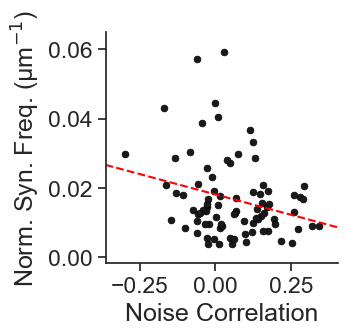

In [9]:
# Ext. Data Fig. 7d/e - new noise corrs from Giulio
cn_type = 'E-to-I' # toggle
cn_type = 'I-to-E'

model_dir =  os.sep.join([cwd, '../modelling','opponent-inhibition-models'])
sys.path.append(model_dir )
sys.path.append(model_dir+'/modules')
sys.path.append(model_dir+'/data')

from RecurrentNets import *
noise_corr_dir = os.sep.join([cwd,'../noise_corr'])
sys.path.append(noise_corr_dir)
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'

Datasets = os.sep.join([noise_corr_dir, 'data/noisecorr_Avg_Combined_rem_1_2_3_4_5_filtt.npy'])
data = load(Datasets, allow_pickle=True).item()
noisecorr_IE = data['noisecorr_IE']
noisecorr_EI = data['noisecorr_EI']
synden_IE = data['synden_IE']
synden_EI = data['synden_EI']

if cn_type == 'E-to-I':
    plot_df = pd.DataFrame({'noise_corr':data['noisecorr_IE'], 'syn_den':data['synden_IE']})
elif cn_type == 'I-to-E':
    plot_df = pd.DataFrame({'noise_corr':data['noisecorr_EI'], 'syn_den':data['synden_EI']})

#sns.set(rc={'figure.figsize':(3,3)}, font_scale=1.5, style='ticks',context='notebook',font='sans-serif')
sns.set(rc={'figure.figsize':(3,3)}, font_scale=1.5, style='ticks')
f, ax0 = plt.subplots(1, 1)

metric = 'pair_select_idx_tmax_new'
if cn_type == 'E-to-I':
    s=50
elif cn_type == 'I-to-E':
    s=25
(c,p)=figs.scatter(plot_df, y='syn_den', x='noise_corr',sig_test='pearson',color= 'k',s=s, ax=ax0)
p = p/2 ### One-tailed test for this!
print('n = %i' % len(plot_df))
print('Data corr = %.3f' % c)
print('t-test p = %.3f' % p) 
#ax0.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax0.set_xlabel('Noise Correlation')  
ax0.set_ylabel('Norm. Syn. Freq. (µm$^{-1}$)')
ax0.get_legend().remove()

sns.despine()
plt.savefig(figsDir+cn_type+'_noisecorr.pdf',bbox_inches='tight')
